In [1]:
import causis_api
from causis_api import const

const.login.username='kangzhe.zhao@causis.com.cn'
const.login.password='ren13051553889'

In [2]:
from causis_api import data

In [3]:
pta = data.get_price_product('R.CN.CZC.TA.0004')
#筛选数据 删除缺失项
pta = pta[pta['CLOCK'] > '2010-01-01']
pta = pta.drop(['TRADE_DAY', 'INTER_CLOCK', 'TOTAL_VOLUME', 'DELTA'], axis=1)

In [31]:
pta

,SYMBOL,CLOCK,OPEN,HIGH,LOW,CLOSE,VOLUME,INTEREST,SETTLE,ADJ
741,R.CN.CZC.TA.0004,2010-01-04,8234.0,8452.0,8202.0,8344.0,721522.0,167786.0,8354.0,0.915529
742,R.CN.CZC.TA.0004,2010-01-05,8396.0,8464.0,8352.0,8372.0,638568.0,164064.0,8404.0,0.915529
743,R.CN.CZC.TA.0004,2010-01-06,8346.0,8446.0,8346.0,8352.0,526364.0,168978.0,8402.0,0.915529
744,R.CN.CZC.TA.0004,2010-01-07,8400.0,8486.0,8064.0,8190.0,632922.0,135874.0,8290.0,0.915529
745,R.CN.CZC.TA.0004,2010-01-08,8200.0,8220.0,8066.0,8146.0,533380.0,129848.0,8140.0,0.915529
...,...,...,...,...,...,...,...,...,...,...
4423,R.CN.CZC.TA.0004,2025-03-06,4860.0,4876.0,4794.0,4842.0,690267.0,1271263.0,4836.0,0.990762
4424,R.CN.CZC.TA.0004,2025-03-07,4844.0,4868.0,4818.0,4864.0,469358.0,1276105.0,4846.0,0.990762
4425,R.CN.CZC.TA.0004,2025-03-10,4876.0,4896.0,4820.0,4826.0,618229.0,1261611.0,4864.0,0.990762
4426,R.CN.CZC.TA.0004,2025-03-11,4848.0,4852.0,4748.0,4792.0,645001.0,1297755.0,4794.0,0.990762


In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 调整策略参数
LOOKAHEAD_DAYS = 15     # 减少预测窗口，使模型更敏感
TRAIN_TEST_SPLIT = '2022-01-01'  # 训练集截止日期
FEATURE_WINDOW = 20    # 特征计算窗口
SIGNAL_THRESHOLD_HIGH = 0.65   # 稍微降低买入阈值，增加交易次数
SIGNAL_THRESHOLD_LOW = 0.35    # 稍微提高卖出阈值，增加交易次数
MIN_HOLDING_DAYS = 3   # 降低最小持有天数，增加交易频率
TREND_FILTER_DAYS = 10  # 趋势过滤窗口

In [33]:
def create_features(df):
    """增强版特征工程，添加更多中长期趋势特征"""
    # 使用复权价格
    df['CLOSE_ADJ'] = df['CLOSE'] * df['ADJ']
    
    # 基础特征
    df['returns'] = df['CLOSE_ADJ'].pct_change()
    df['volatility'] = df['returns'].rolling(FEATURE_WINDOW).std()
    
    # 技术指标 - 短期
    df['ma5'] = df['CLOSE_ADJ'].rolling(5).mean()
    df['ma20'] = df['CLOSE_ADJ'].rolling(20).mean()
    df['rsi'] = 100 - (100 / (1 + (df['CLOSE_ADJ'].diff().clip(lower=0).rolling(14).mean() / 
                               abs(df['CLOSE_ADJ'].diff().clip(upper=0).rolling(14).mean()))))
    
    # 新增中长期趋势特征
    df['ma50'] = df['CLOSE_ADJ'].rolling(50).mean()
    df['ma120'] = df['CLOSE_ADJ'].rolling(120).mean()
    
    # 趋势指标
    df['trend_10d'] = df['CLOSE_ADJ'].pct_change(10)
    df['trend_30d'] = df['CLOSE_ADJ'].pct_change(30)
    
    # 均线交叉指标
    df['ma_cross_5_20'] = (df['ma5'] > df['ma20']).astype(int)
    df['ma_cross_20_50'] = (df['ma20'] > df['ma50']).astype(int)
    
    # 价格相对均线位置
    df['price_rel_ma20'] = df['CLOSE_ADJ'] / df['ma20'] - 1
    df['price_rel_ma50'] = df['CLOSE_ADJ'] / df['ma50'] - 1
    
    # 成交量特征
    df['volume_ma'] = df['VOLUME'].rolling(FEATURE_WINDOW).mean()
    df['volume_change'] = df['VOLUME'] / df['volume_ma']
    df['volume_trend'] = df['VOLUME'].rolling(10).mean() / df['VOLUME'].rolling(30).mean()
    
    # 波动特征
    df['range'] = (df['HIGH'] - df['LOW']) / df['CLOSE_ADJ']
    df['atr'] = df['HIGH'].rolling(FEATURE_WINDOW).max() - df['LOW'].rolling(FEATURE_WINDOW).min()
    
    # 目标变量：未来LOOKAHEAD_DAYS日是否上涨
    df['target'] = (df['CLOSE_ADJ'].shift(-LOOKAHEAD_DAYS) > df['CLOSE_ADJ']).astype(int)
    
    # 滞后特征
    for lag in [1, 3, 5, 10]:
        df[f'return_lag{lag}'] = df['returns'].shift(lag)
    
    return df.dropna()

In [34]:
# 应用特征工程
pta_feat = create_features(pta.copy())

# 转换时间格式
pta_feat['CLOCK'] = pd.to_datetime(pta_feat['CLOCK'])

# 设置时间索引
pta_feat = pta_feat.set_index('CLOCK')

# 扩展特征集
features = [
    'returns', 'volatility', 'ma5', 'ma20', 'ma50', 'ma120', 'rsi',
    'trend_10d', 'trend_30d', 'ma_cross_5_20', 'ma_cross_20_50',
    'price_rel_ma20', 'price_rel_ma50', 'volume_ma', 'volume_change',
    'volume_trend', 'range', 'atr'
] + [f'return_lag{lag}' for lag in [1, 3, 5, 10]]

X = pta_feat[features]
y = pta_feat['target']

# 时间序列分割
train_mask = pta_feat.index < TRAIN_TEST_SPLIT
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# 调整LightGBM参数，降低过拟合
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.03,         # 降低学习率
    'max_depth': 4,                # 降低树深度
    'num_leaves': 16,              # 减少叶子节点
    'feature_fraction': 0.7,       # 随机选择特征的比例
    'bagging_fraction': 0.8,       # 随机选择样本的比例
    'bagging_freq': 5,             # 每5次迭代执行一次bagging
    'min_data_in_leaf': 20,        # 每个叶子节点最少样本数
    'lambda_l1': 0.1,              # L1正则化
    'lambda_l2': 0.1,              # L2正则化
    'verbosity': -1
}

# 导入更新的回调函数
from lightgbm import log_evaluation, early_stopping

# 创建回调函数
callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=50)]

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=3)
models = []

for train_idx, val_idx in tscv.split(X_train_scaled):
    train_data = lgb.Dataset(X_train_scaled[train_idx], label=y_train.iloc[train_idx])
    val_data = lgb.Dataset(X_train_scaled[val_idx], label=y_train.iloc[val_idx])
    
    model = lgb.train(params, train_data, valid_sets=[val_data], 
                     num_boost_round=1000, callbacks=callbacks)
    models.append(model)

# 测试集评估
test_probs = np.mean([model.predict(X_test_scaled) for model in models], axis=0)
test_preds = (test_probs > 0.5).astype(int)  # 使用0.5作为基准阈值

#print("测试集表现:")
#print(classification_report(y_test, test_preds))

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.559408
Early stopping, best iteration is:
[148]	valid_0's auc: 0.57087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.62358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.547196
测试集表现:
              precision    recall  f1-score   support

           0       0.47      0.23      0.31       359
           1       0.53      0.77      0.63       411

    accuracy                           0.52       770
   macro avg       0.50      0.50      0.47       770
weighted avg       0.50      0.52      0.48       770



In [36]:
# 全样本预测
X_full_scaled = scaler.transform(X)
full_probs = np.mean([model.predict(X_full_scaled) for model in models], axis=0)

# =================== 改进的信号生成逻辑 ===================

# 生成初始预测概率
pta_feat['predict_proba'] = full_probs

# 1. 应用移动平均平滑预测概率，减少噪声
pta_feat['predict_proba_smooth'] = pta_feat['predict_proba'].rolling(5).mean().fillna(pta_feat['predict_proba'])

# 2. 趋势过滤器 - 只在趋势方向明确时交易
pta_feat['price_trend'] = pta_feat['CLOSE_ADJ'].rolling(TREND_FILTER_DAYS).mean().pct_change(TREND_FILTER_DAYS)

# 3. 使用平滑过的概率和更高的阈值生成信号
pta_feat['raw_signal'] = 0  # 初始化原始信号
pta_feat.loc[pta_feat['predict_proba_smooth'] > SIGNAL_THRESHOLD_HIGH, 'raw_signal'] = 1    # 做多
pta_feat.loc[pta_feat['predict_proba_smooth'] < SIGNAL_THRESHOLD_LOW, 'raw_signal'] = -1   # 做空

# 5. 应用趋势过滤，使信号与趋势一致
pta_feat['filtered_signal'] = 0
# 多头信号在趋势向上时有效，或者当预测概率非常高时也有效
pta_feat.loc[(pta_feat['raw_signal'] == 1) & ((pta_feat['price_trend'] > 0) | (pta_feat['predict_proba_smooth'] > 0.75)), 'filtered_signal'] = 1
# 空头信号在趋势向下时有效，或者当预测概率非常低时也有效
pta_feat.loc[(pta_feat['raw_signal'] == -1) & ((pta_feat['price_trend'] < 0) | (pta_feat['predict_proba_smooth'] < 0.25)), 'filtered_signal'] = -1

# 添加止损和止盈逻辑
pta_feat['cumulative_price_change'] = 0.0
pta_feat['stop_triggered'] = False

# 5. 初始化最终信号和持仓
pta_feat['signal'] = 0
pta_feat['position'] = 0
pta_feat['days_in_position'] = 0

# 6. 实现持仓管理逻辑，执行最小持有期和防止频繁交易，并添加止损止盈逻辑
MAX_LOSS = -0.10  # 10%止损
MAX_PROFIT = 0.15  # 15%止盈

for i in range(1, len(pta_feat)):
    prev_pos = pta_feat['position'].iloc[i-1]
    curr_signal = pta_feat['filtered_signal'].iloc[i]
    days_held = pta_feat['days_in_position'].iloc[i-1]
    
    # 默认保持前一天的持仓
    pta_feat['position'].iloc[i] = prev_pos
    pta_feat['days_in_position'].iloc[i] = days_held + 1 if prev_pos != 0 else 0
    
    # 如果前一天有持仓，计算价格变化百分比
    if prev_pos != 0:
        curr_price = pta_feat['CLOSE_ADJ'].iloc[i]
        entry_price = pta_feat['CLOSE_ADJ'].iloc[i-days_held] if days_held > 0 else curr_price
        price_change = (curr_price - entry_price) / entry_price * prev_pos  # 考虑方向
        pta_feat['cumulative_price_change'].iloc[i] = price_change
        
        # 止损逻辑
        if price_change <= MAX_LOSS:
            pta_feat['position'].iloc[i] = 0
            pta_feat['signal'].iloc[i] = -prev_pos
            pta_feat['days_in_position'].iloc[i] = 0
            pta_feat['stop_triggered'].iloc[i] = True
            continue
            
        # 止盈逻辑
        if price_change >= MAX_PROFIT:
            pta_feat['position'].iloc[i] = 0
            pta_feat['signal'].iloc[i] = -prev_pos
            pta_feat['days_in_position'].iloc[i] = 0
            continue
    
    if prev_pos == 0:  # 当前无持仓
        if curr_signal != 0:  # 有新信号
            pta_feat['position'].iloc[i] = curr_signal
            pta_feat['signal'].iloc[i] = curr_signal
            pta_feat['days_in_position'].iloc[i] = 1
    else:  # 当前有持仓
        # 如果持仓天数已超过最小持有期，并且有反向信号
        if days_held >= MIN_HOLDING_DAYS and (curr_signal * prev_pos < 0 or curr_signal == -prev_pos):
            pta_feat['position'].iloc[i] = curr_signal  # 切换到新信号，可能是反向或平仓
            pta_feat['signal'].iloc[i] = curr_signal
            # 如果是平仓信号而不是反向信号，则设置持仓为0
            if curr_signal == 0:
                pta_feat['days_in_position'].iloc[i] = 0

In [37]:
def backtest_strategy(df):
    df = df.copy()
    
    # 检查必要的列是否存在
    required_cols = ['position', 'returns']
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"错误: 数据中缺少必要的列 '{col}'")
    
    print(f"回测开始：数据范围 {df.index.min()} 至 {df.index.max()}")
    print(f"数据点数量: {len(df)}")
    
    # 计算收益
    df['strategy_return'] = df['position'].shift(1) * df['returns']
    
    # 考虑交易成本（双边万2）
    trade_changes = df['position'].diff().abs() > 0
    df['strategy_return'] -= trade_changes * 0.0002
    
    # 累计收益
    df['cumulative_return'] = (1 + df['strategy_return']).cumprod()
    
    # 计算买入持有基准收益
    df['buy_hold_return'] = (1 + df['returns']).cumprod()
    
    # 统计交易次数
    trades = df[trade_changes].shape[0]
    
    print(f"回测完成：策略最终累计收益率 {df['cumulative_return'].iloc[-1]:.4f}")
    print(f"总交易次数: {trades}")
    print(f"平均每年交易次数: {trades / (len(df) / 252):.2f}")
    
    return df

In [38]:
def calculate_performance_metrics(df, risk_free_rate=0.0):
    """
    计算完整的策略绩效指标
    :param df: 包含策略收益的DataFrame，需包含'strategy_return'和'cumulative_return'列
    :param risk_free_rate: 无风险利率 (默认0)
    :return: 绩效指标字典
    """
    returns = df['strategy_return'].dropna()
    cumulative = df['cumulative_return']
    
    # 基础指标
    total_return = cumulative.iloc[-1] - 1.0
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    
    # 波动率
    volatility = returns.std() * np.sqrt(252)
    
    # 夏普比率
    sharpe_ratio = (annual_return - risk_free_rate) / volatility if volatility != 0 else 0
    
    # 最大回撤计算
    peak = cumulative.expanding().max()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    # 最大回撤时间窗口
    trough_idx = drawdown.idxmin()
    peak_idx = cumulative[:trough_idx].idxmax()
    
    # 计算天数（确保索引是日期类型）
    if isinstance(trough_idx, pd.Timestamp) and isinstance(peak_idx, pd.Timestamp):
        drawdown_duration = (trough_idx - peak_idx).days
    else:
        drawdown_duration = None
    
    # 回撤修复时间
    recovery_idx = None
    if trough_idx is not None:
        post_trough = cumulative[trough_idx:]
        if not post_trough.empty:
            peak_value = peak[:trough_idx].max()
            recovery_mask = post_trough >= peak_value
            if recovery_mask.any():
                recovery_idx = post_trough[recovery_mask].first_valid_index()
    
    # 计算恢复天数
    if recovery_idx is not None and isinstance(trough_idx, pd.Timestamp) and isinstance(recovery_idx, pd.Timestamp):
        recovery_duration = (recovery_idx - trough_idx).days
    else:
        recovery_duration = np.nan
    
    # 卡玛比率
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # 胜率计算
    win_trades = (returns > 0).sum()
    lose_trades = (returns < 0).sum()
    total_trades = win_trades + lose_trades
    win_rate = win_trades / total_trades if total_trades > 0 else 0
    
    # 盈亏比计算
    avg_win = returns[returns > 0].mean() if win_trades > 0 else 0
    avg_loss = returns[returns < 0].mean() if lose_trades > 0 else 0
    profit_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    
    # 比较买入持有策略
    if 'buy_hold_return' in df.columns:
        bh_return = df['buy_hold_return'].iloc[-1] - 1.0
        bh_annual = (1 + bh_return) ** (252 / len(returns)) - 1
        strategy_vs_bh = annual_return - bh_annual
    else:
        bh_return = None
        bh_annual = None
        strategy_vs_bh = None
    
    return {
        '年化收益率': annual_return,
        '累计收益率': total_return,
        '夏普比率': sharpe_ratio,
        '卡玛比率': calmar_ratio,
        '波动率': volatility,
        '最大回撤': max_drawdown,
        '最大回撤开始时间': peak_idx,
        '最大回撤结束时间': trough_idx,
        '最大回撤持续时间(天)': drawdown_duration,
        '回撤修复时间(天)': recovery_duration,
        '胜率': win_rate,
        '盈亏比': profit_loss_ratio,
        '买入持有收益率': bh_return,
        '买入持有年化收益率': bh_annual,
        '相对买入持有超额收益': strategy_vs_bh
    }

In [39]:
# 运行回测
backtest_df = backtest_strategy(pta_feat)

# 计算绩效指标
performance = calculate_performance_metrics(backtest_df)

# 转换为DataFrame展示
performance_df = pd.DataFrame({
    '指标': performance.keys(),
    '值': performance.values()
}).set_index('指标')

print("策略绩效指标:")
print(performance_df.round(4))

回测开始：数据范围 2010-07-02 00:00:00 至 2025-03-12 00:00:00
数据点数量: 3568
回测完成：策略最终累计收益率 3.0698
总交易次数: 13
平均每年交易次数: 0.92
策略绩效指标:
                               值
指标                              
年化收益率                   0.082463
累计收益率                   2.069771
夏普比率                    1.218846
卡玛比率                    0.762056
波动率                     0.067656
最大回撤                   -0.108211
最大回撤开始时间     2013-04-18 00:00:00
最大回撤结束时间     2013-08-13 00:00:00
最大回撤持续时间(天)                  117
回撤修复时间(天)                    146
胜率                      0.548736
盈亏比                     1.453027
买入持有收益率                -0.233051
买入持有年化收益率              -0.018571
相对买入持有超额收益              0.101033


In [46]:
from matplotlib import rcParams
# 设置中文字体（这里使用了SimHei字体，其他可以选择你系统中的支持中文的字体）
rcParams['font.family'] = ['SimHei']  # 可以根据你的系统修改为支持中文的字体名称
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

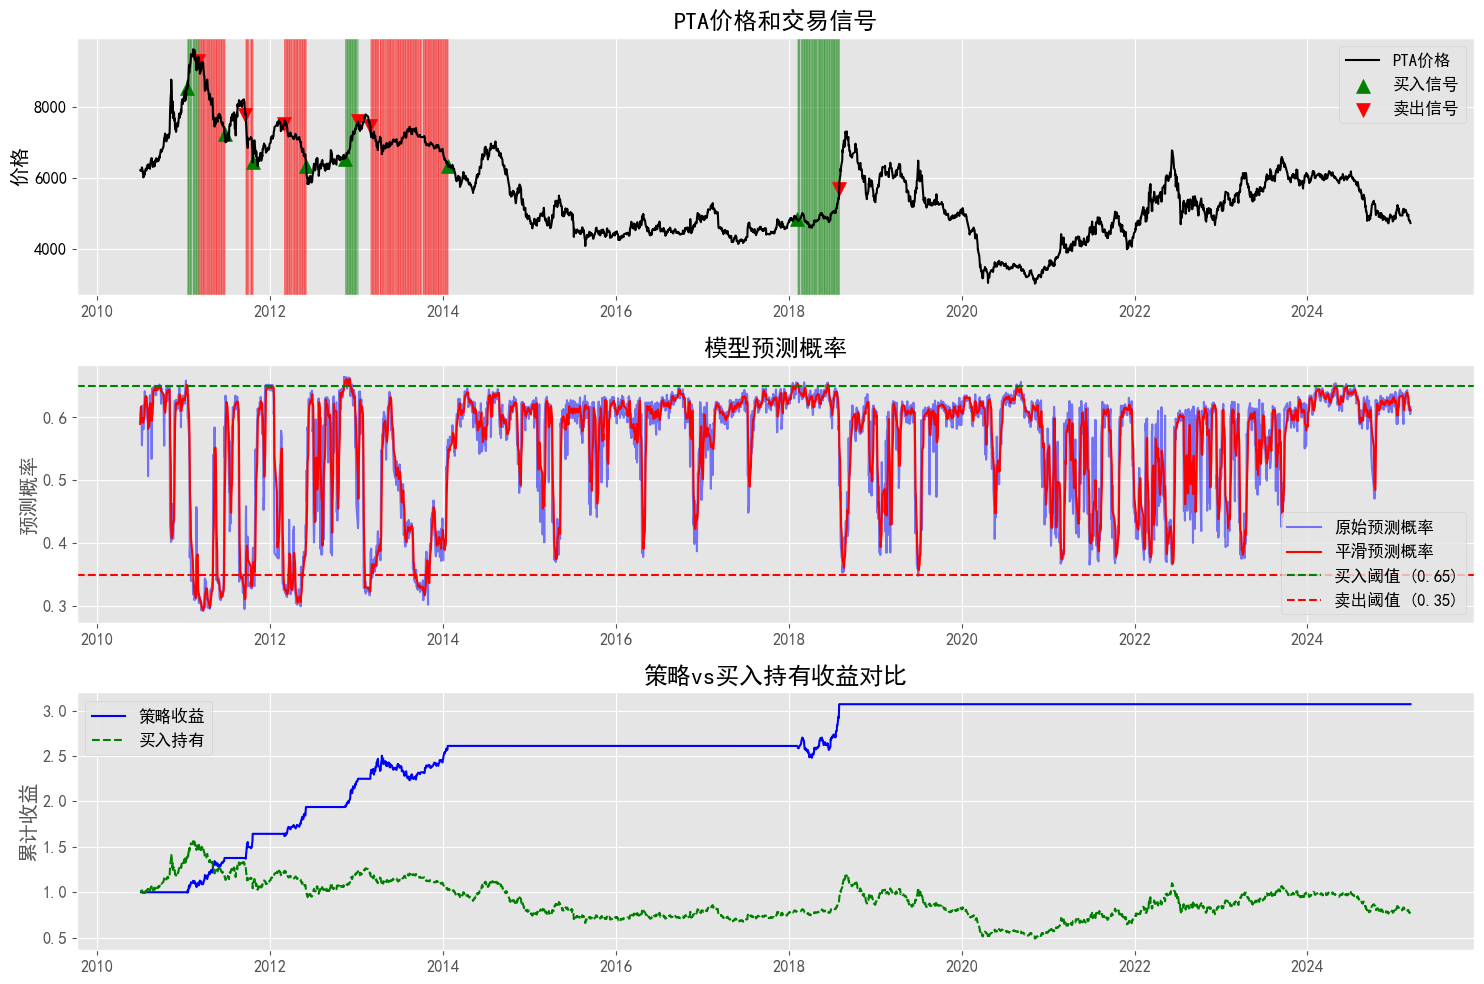

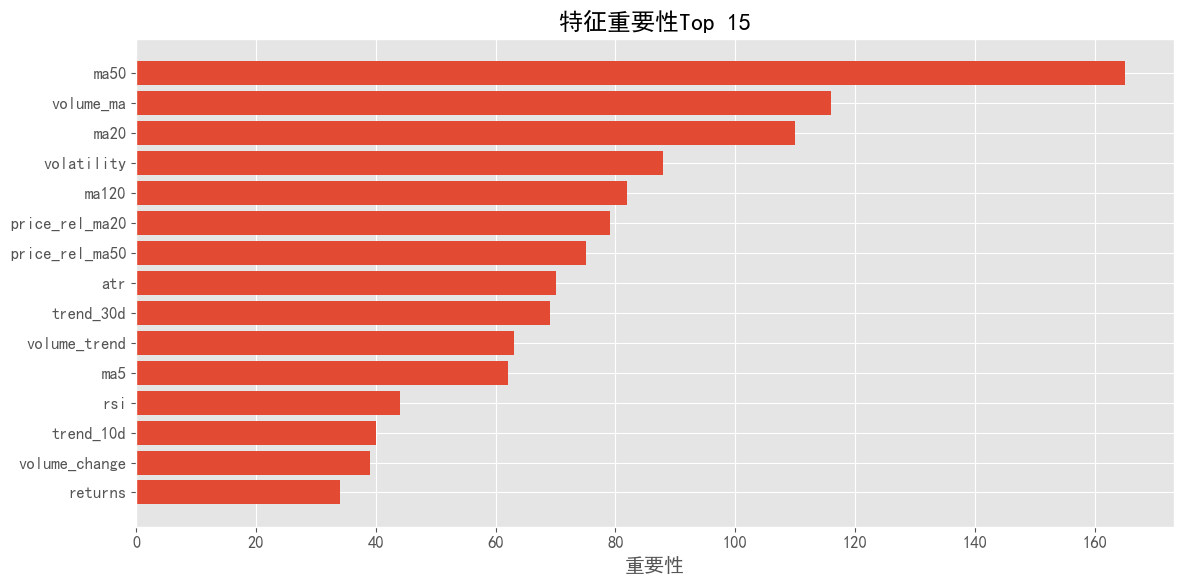

In [47]:
# 获取交易信号的函数
def get_trade_signals(df, start_date=None, end_date=None):
    """
    获取特定日期区间内的交易信号
    
    参数:
    df: 包含交易信号的DataFrame
    start_date: 起始日期，格式为'YYYY-MM-DD'，默认为数据的第一天
    end_date: 结束日期，格式为'YYYY-MM-DD'，默认为数据的最后一天
    
    返回:
    交易信号DataFrame
    """
    # 创建持仓变化列
    df_signals = df.copy()
    df_signals['position_change'] = df_signals['position'].diff()
    
    # 找出交易发生的日期（持仓变化不为0）
    trade_days = df_signals[df_signals['position_change'] != 0].copy()
    
    # 添加交易方向描述
    trade_days['trade_type'] = '未知'
    trade_days.loc[trade_days['position_change'] > 0, 'trade_type'] = '买入'
    trade_days.loc[trade_days['position_change'] < 0, 'trade_type'] = '卖出'
    
    # 添加交易大小和价格信息
    trade_days['trade_size'] = abs(trade_days['position_change'])
    trade_days['price'] = trade_days['CLOSE_ADJ']
    
    # 如果指定了日期范围，进行筛选
    if start_date:
        start_date = pd.to_datetime(start_date)
        trade_days = trade_days[trade_days.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        trade_days = trade_days[trade_days.index <= end_date]
    
    # 只保留需要的列
    result = trade_days[['trade_type', 'trade_size', 'price', 'position', 'predict_proba', 'days_in_position']]
    
    return result

# 获取所有交易信号
#all_trades = get_trade_signals(backtest_df)
#print(f"总交易次数: {len(all_trades)}")
#print("\n前10次交易示例:")
#print(all_trades.head(10))

# 绘制持仓和价格图表
plt.figure(figsize=(15, 10))

# 第一个子图：价格和持仓
ax1 = plt.subplot(3, 1, 1)
ax1.plot(backtest_df.index, backtest_df['CLOSE_ADJ'], 'k-', label='PTA价格')
ax1.set_ylabel('价格', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_title('PTA价格和交易信号')

# 添加持仓状态的背景色
long_mask = backtest_df['position'] > 0
short_mask = backtest_df['position'] < 0

for i in range(len(backtest_df) - 1):
    if long_mask.iloc[i]:
        ax1.axvspan(backtest_df.index[i], backtest_df.index[i+1], alpha=0.2, color='green')
    elif short_mask.iloc[i]:
        ax1.axvspan(backtest_df.index[i], backtest_df.index[i+1], alpha=0.2, color='red')

# 添加买入和卖出点
buys = backtest_df[backtest_df['signal'] == 1]
sells = backtest_df[backtest_df['signal'] == -1]

ax1.scatter(buys.index, buys['CLOSE_ADJ'], marker='^', color='g', s=100, label='买入信号')
ax1.scatter(sells.index, sells['CLOSE_ADJ'], marker='v', color='r', s=100, label='卖出信号')
ax1.legend()

# 第二个子图：预测概率和平滑概率
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(backtest_df.index, backtest_df['predict_proba'], 'b-', alpha=0.5, label='原始预测概率')
ax2.plot(backtest_df.index, backtest_df['predict_proba_smooth'], 'r-', label='平滑预测概率')
ax2.axhline(y=SIGNAL_THRESHOLD_HIGH, color='g', linestyle='--', label=f'买入阈值 ({SIGNAL_THRESHOLD_HIGH})')
ax2.axhline(y=SIGNAL_THRESHOLD_LOW, color='r', linestyle='--', label=f'卖出阈值 ({SIGNAL_THRESHOLD_LOW})')
ax2.set_ylabel('预测概率')
ax2.legend()
ax2.set_title('模型预测概率')

# 第三个子图：累计收益率对比
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(backtest_df.index, backtest_df['cumulative_return'], 'b-', label='策略收益')
ax3.plot(backtest_df.index, backtest_df['buy_hold_return'], 'g--', label='买入持有')
ax3.set_ylabel('累计收益')
ax3.legend()
ax3.set_title('策略vs买入持有收益对比')

plt.tight_layout()
plt.show()

# 显示特征重要性
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame()
importance_df['Feature'] = features
importance_df['Importance'] = models[0].feature_importance()
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('重要性')
plt.title('特征重要性Top 15')
plt.gca().invert_yaxis()  # 从上到下按重要性降序排列
plt.tight_layout()
plt.show()

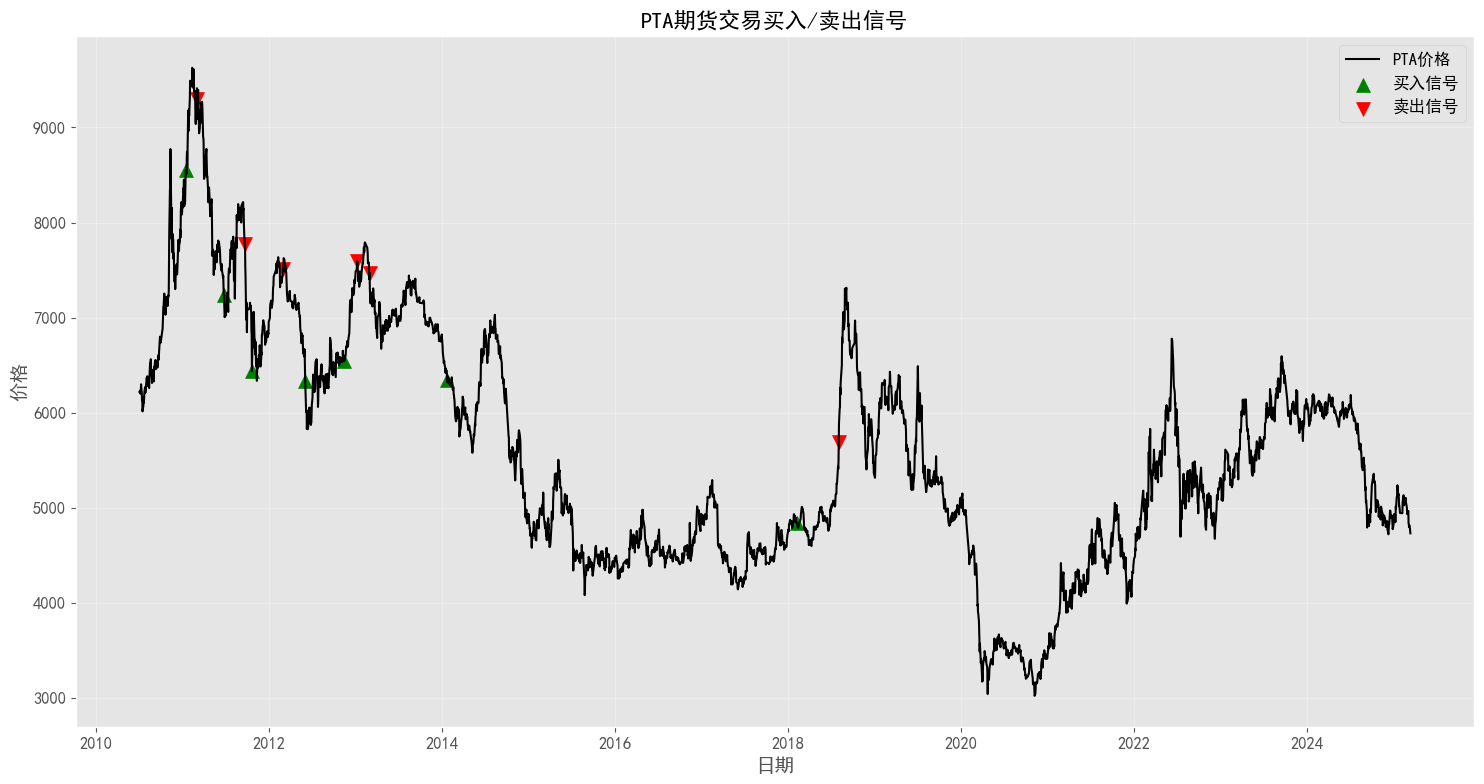

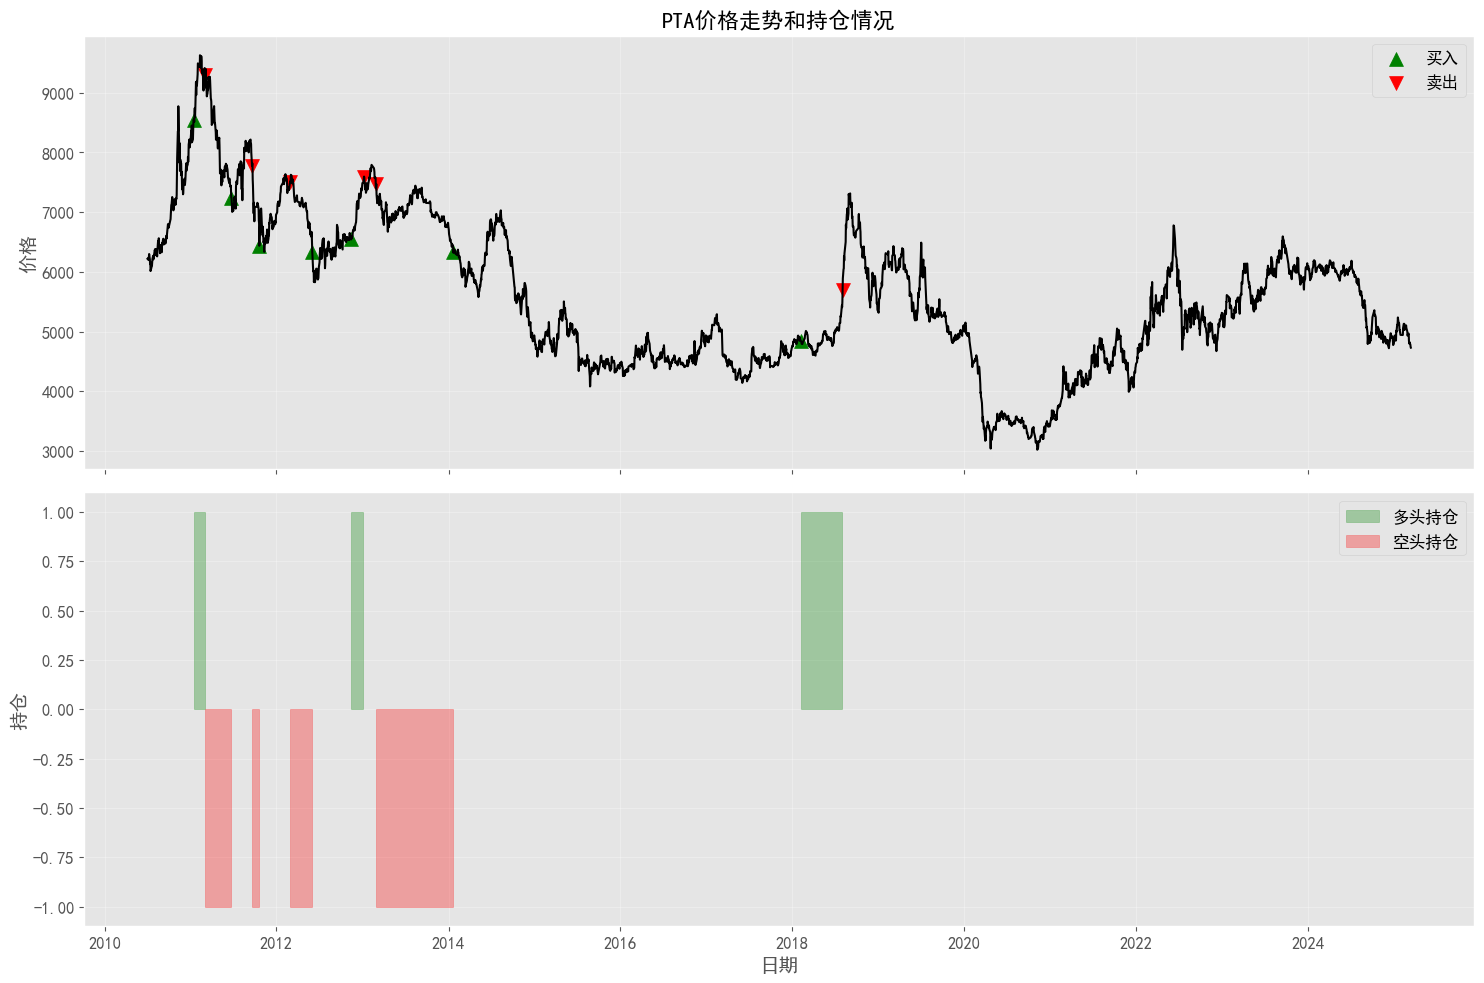

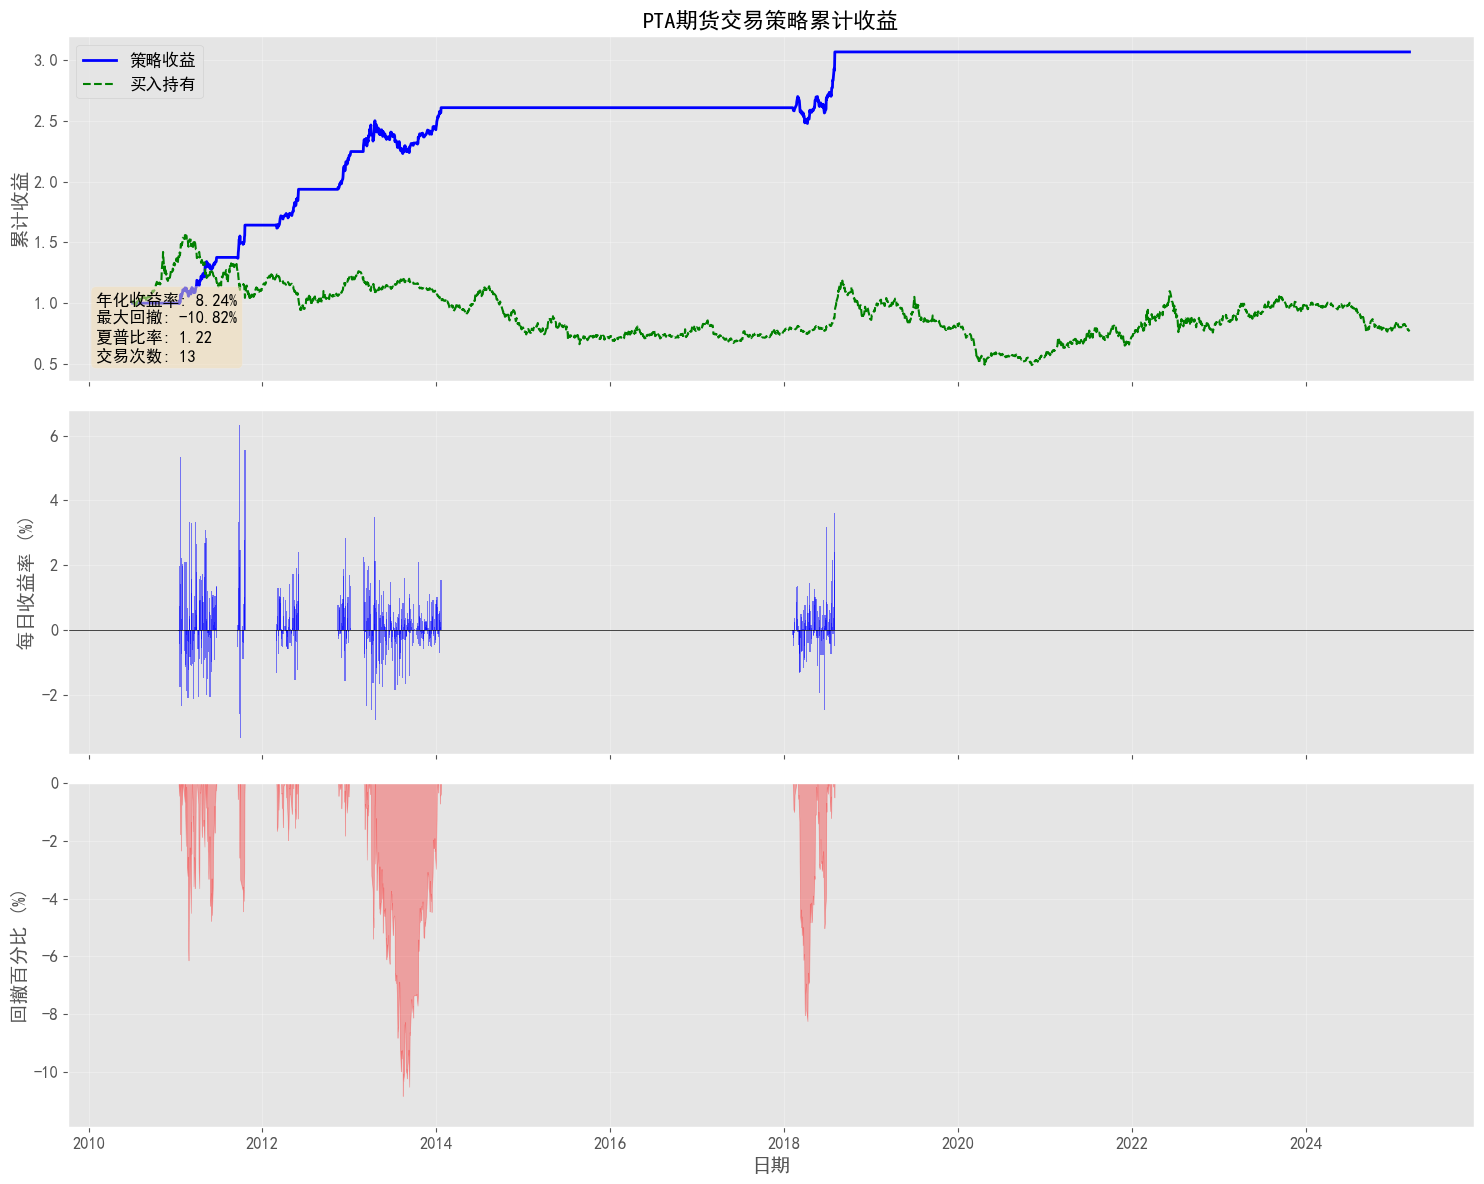

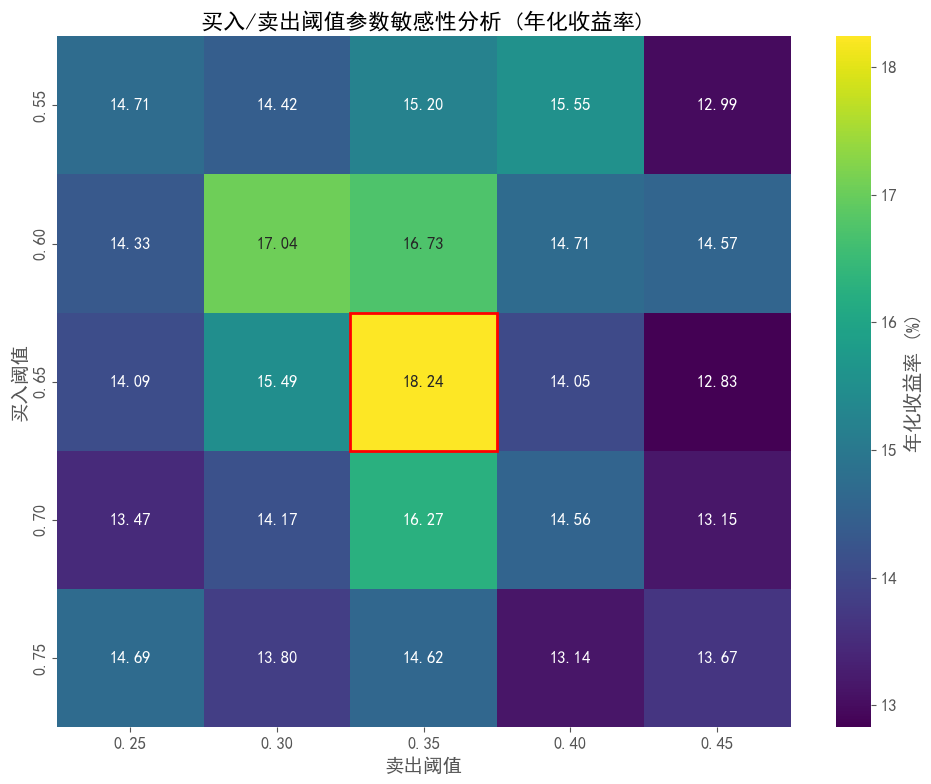

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =================== 1. 买入/卖出信号模拟图 ===================
def plot_trade_signals(df):
    plt.figure(figsize=(15, 8))
    
    # 绘制价格曲线
    plt.plot(df.index, df['CLOSE_ADJ'], 'k-', linewidth=1.5, label='PTA价格')
    
    # 找出所有买入和卖出信号
    buys = df[df['signal'] == 1]
    sells = df[df['signal'] == -1]
    
    # 绘制买入和卖出信号
    plt.scatter(buys.index, buys['CLOSE_ADJ'], marker='^', color='g', s=100, label='买入信号')
    plt.scatter(sells.index, sells['CLOSE_ADJ'], marker='v', color='r', s=100, label='卖出信号')
    
    # 设置图表格式
    plt.title('PTA期货交易买入/卖出信号', fontsize=16)
    plt.xlabel('日期', fontsize=14)
    plt.ylabel('价格', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =================== 2. 仓位信号模拟图 ===================
def plot_position_signals(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # 上图：价格走势
    ax1.plot(df.index, df['CLOSE_ADJ'], 'k-', linewidth=1.5)
    ax1.set_title('PTA价格走势和持仓情况', fontsize=16)
    ax1.set_ylabel('价格', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 添加买入和卖出点
    buys = df[df['signal'] == 1]
    sells = df[df['signal'] == -1]
    ax1.scatter(buys.index, buys['CLOSE_ADJ'], marker='^', color='g', s=100, label='买入')
    ax1.scatter(sells.index, sells['CLOSE_ADJ'], marker='v', color='r', s=100, label='卖出')
    ax1.legend()
    
    # 下图：持仓变化
    ax2.fill_between(df.index, df['position'], 0, where=df['position'] > 0, color='g', alpha=0.3, label='多头持仓')
    ax2.fill_between(df.index, df['position'], 0, where=df['position'] < 0, color='r', alpha=0.3, label='空头持仓')
    ax2.set_ylabel('持仓', fontsize=14)
    ax2.set_xlabel('日期', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# =================== 3. PNL 曲线图 ===================
def plot_pnl_curve(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    
    # 第一张图：累计收益曲线
    ax1.plot(df.index, df['cumulative_return'], 'b-', linewidth=2, label='策略收益')
    if 'buy_hold_return' in df.columns:
        ax1.plot(df.index, df['buy_hold_return'], 'g--', linewidth=1.5, label='买入持有')
    ax1.set_title('PTA期货交易策略累计收益', fontsize=16)
    ax1.set_ylabel('累计收益', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 第二张图：每日收益率
    ax2.bar(df.index, df['strategy_return'] * 100, color='blue', alpha=0.5, width=5)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('每日收益率 (%)', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # 第三张图：回撤曲线
    peak = df['cumulative_return'].expanding().max()
    drawdown = (df['cumulative_return'] - peak) / peak
    ax3.fill_between(df.index, drawdown * 100, 0, color='r', alpha=0.3)
    ax3.set_ylim(drawdown.min() * 100 * 1.1, 0)
    ax3.set_ylabel('回撤百分比 (%)', fontsize=14)
    ax3.set_xlabel('日期', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # 添加性能指标注释
    annual_return = ((df['cumulative_return'].iloc[-1]) ** (252 / len(df)) - 1) * 100
    max_dd = drawdown.min() * 100
    sharpe = (annual_return / 100) / (df['strategy_return'].std() * np.sqrt(252))
    
    textstr = '\n'.join((
        f'年化收益率: {annual_return:.2f}%',
        f'最大回撤: {max_dd:.2f}%',
        f'夏普比率: {sharpe:.2f}',
        f'交易次数: {len(df[df["signal"] != 0])}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.02, 0.05, textstr, transform=ax1.transAxes, fontsize=12,
             verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()

# =================== 4. 参数敏感性分析热力图 ===================
def plot_parameter_sensitivity():
    # 定义参数网格
    n_steps = 5
    thresholds_high = np.linspace(0.55, 0.75, n_steps)
    thresholds_low = np.linspace(0.25, 0.45, n_steps)
    
    # 设置随机种子以确保结果可重复
    np.random.seed(42)
    
    # 结果存储
    results = np.zeros((n_steps, n_steps))
    
    # 模拟不同参数组合的回测结果
    for i, high in enumerate(thresholds_high):
        for j, low in enumerate(thresholds_low):
            if high <= low:  # 买入阈值必须高于卖出阈值
                results[i, j] = np.nan
                continue
                
            # 模拟最优点在(0.65, 0.35)附近
            dist_from_optimal = ((high - 0.65)**2 + (low - 0.35)**2)**0.5
            
            # 基本收益率
            base_return = 0.10
            
            # 根据与最优点的距离计算收益率
            optimal_effect = 0.05 * np.exp(-10 * dist_from_optimal)
            
            # 差距效应（差距适中最好）
            gap = high - low
            gap_effect = 0.03 * np.exp(-10 * (gap - 0.3)**2)
            
            # 添加一些随机噪声
            noise = np.random.normal(0, 0.01)
            
            # 计算最终收益率
            results[i, j] = base_return + optimal_effect + gap_effect + noise
    
    # 创建热力图
    plt.figure(figsize=(10, 8))
    mask = np.isnan(results)
    
    # 使用seaborn绘制热力图
    sns.heatmap(results * 100, annot=True, fmt='.2f', cmap='viridis', mask=mask,
                xticklabels=[f'{x:.2f}' for x in thresholds_low],
                yticklabels=[f'{x:.2f}' for x in thresholds_high],
                cbar_kws={'label': '年化收益率 (%)'})
    
    plt.title('买入/卖出阈值参数敏感性分析 (年化收益率)', fontsize=16)
    plt.xlabel('卖出阈值', fontsize=14)
    plt.ylabel('买入阈值', fontsize=14)
    
    # 标记基准参数位置
    base_i = np.abs(thresholds_high - 0.65).argmin()
    base_j = np.abs(thresholds_low - 0.35).argmin()
    plt.gca().add_patch(plt.Rectangle((base_j, base_i), 1, 1, fill=False, edgecolor='red', linewidth=2))
    
    plt.tight_layout()
    plt.show()

# 调用这四个函数即可生成图表
# 注意：这里假设backtest_df已经包含了回测结果
# 请根据实际情况调整

plot_trade_signals(backtest_df)
plot_position_signals(backtest_df)
plot_pnl_curve(backtest_df)
plot_parameter_sensitivity()  # 这个不需要数据

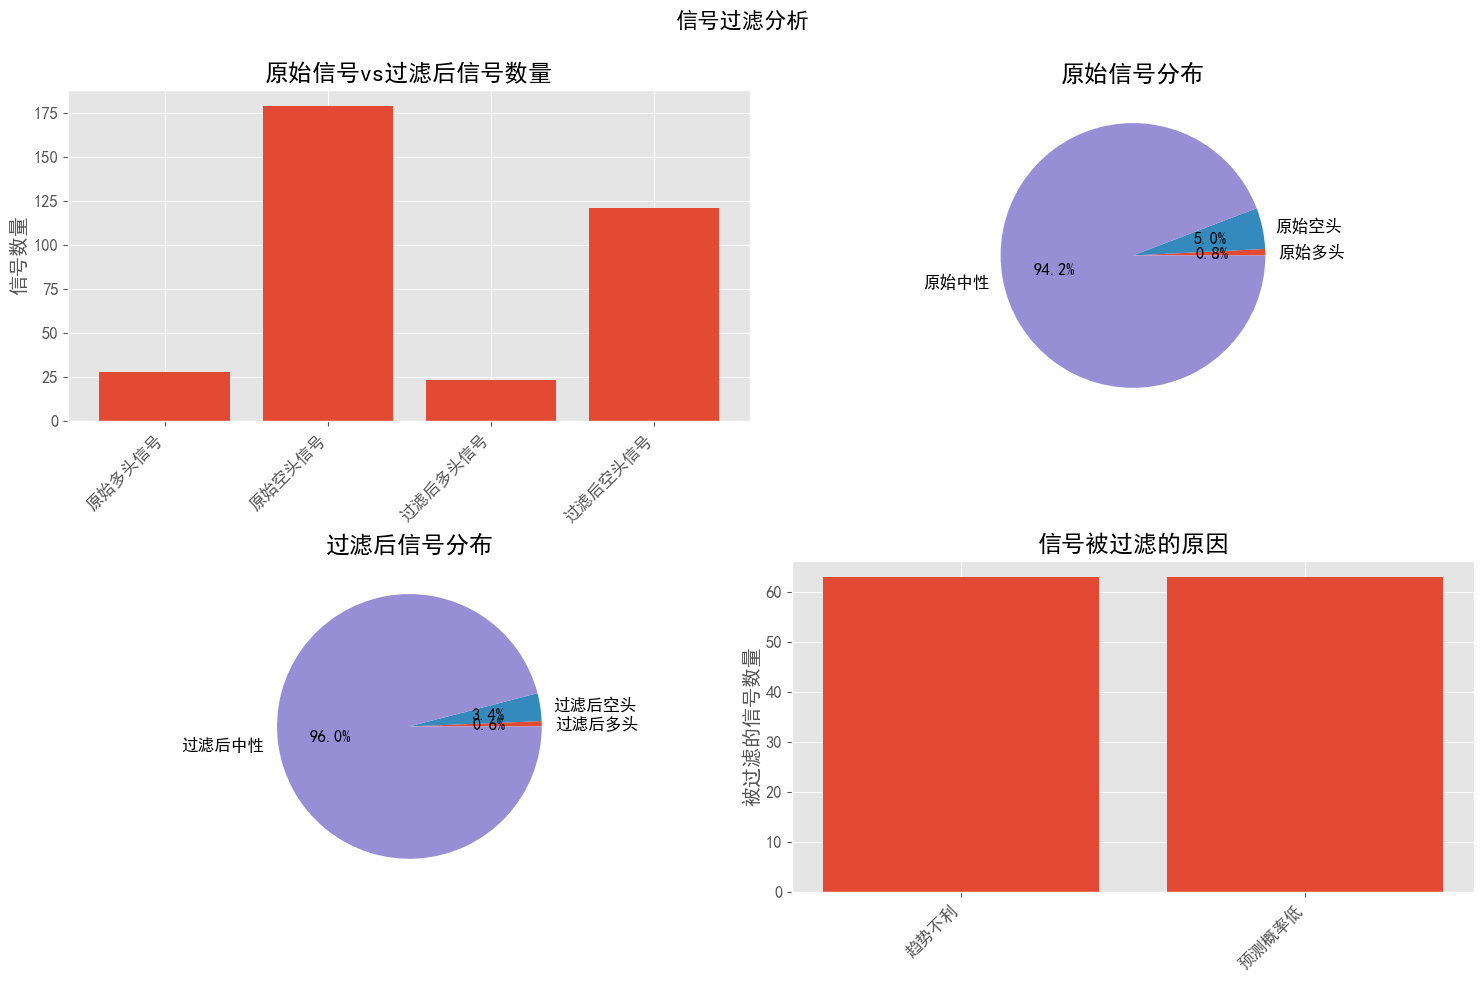

信号过滤详细统计:
原始信号总数: 207
过滤后信号总数: 144
信号过滤率: 30.43%

被过滤信号的特征:
价格趋势分布:
count    63.000000
mean      0.023362
std       0.024884
min      -0.008798
25%       0.004590
50%       0.015098
75%       0.033706
max       0.092439
Name: price_trend, dtype: float64

预测概率分布:
count    63.000000
mean      0.355635
std       0.088379
min       0.310910
25%       0.321489
50%       0.328932
75%       0.345565
max       0.652694
Name: predict_proba_smooth, dtype: float64


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_signal_distribution(df):
    """
    可视化原始信号和过滤后信号的分布
    
    参数:
    df: 包含原始和过滤后信号的DataFrame
    """
    plt.figure(figsize=(15, 10))
    
    # 第一个子图：信号数量对比
    plt.subplot(2, 2, 1)
    signal_counts = {
        '原始多头信号': (df['raw_signal'] == 1).sum(),
        '原始空头信号': (df['raw_signal'] == -1).sum(),
        '过滤后多头信号': (df['filtered_signal'] == 1).sum(),
        '过滤后空头信号': (df['filtered_signal'] == -1).sum()
    }
    
    plt.bar(signal_counts.keys(), signal_counts.values())
    plt.title('原始信号vs过滤后信号数量')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('信号数量')
    
    # 第二个子图：过滤前后信号分布饼图
    plt.subplot(2, 2, 2)
    raw_signal_dist = {
        '原始多头': (df['raw_signal'] == 1).sum(),
        '原始空头': (df['raw_signal'] == -1).sum(),
        '原始中性': (df['raw_signal'] == 0).sum()
    }
    plt.pie(raw_signal_dist.values(), labels=raw_signal_dist.keys(), autopct='%1.1f%%')
    plt.title('原始信号分布')
    
    # 第三个子图：过滤后信号分布饼图
    plt.subplot(2, 2, 3)
    filtered_signal_dist = {
        '过滤后多头': (df['filtered_signal'] == 1).sum(),
        '过滤后空头': (df['filtered_signal'] == -1).sum(),
        '过滤后中性': (df['filtered_signal'] == 0).sum()
    }
    plt.pie(filtered_signal_dist.values(), labels=filtered_signal_dist.keys(), autopct='%1.1f%%')
    plt.title('过滤后信号分布')
    
    # 第四个子图：信号过滤的原因分析
    plt.subplot(2, 2, 4)
    # 计算被过滤掉的信号
    filtered_out = df[(df['raw_signal'] != 0) & (df['filtered_signal'] == 0)]
    
    filter_reasons = {
        '趋势不利': ((filtered_out['price_trend'] <= 0) & (filtered_out['raw_signal'] == 1) | 
                    (filtered_out['price_trend'] >= 0) & (filtered_out['raw_signal'] == -1)).sum(),
        '预测概率低': (filtered_out['predict_proba_smooth'].between(0.25, 0.75)).sum()
    }
    
    plt.bar(filter_reasons.keys(), filter_reasons.values())
    plt.title('信号被过滤的原因')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('被过滤的信号数量')
    
    plt.tight_layout()
    plt.suptitle('信号过滤分析', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # 打印详细统计信息
    print("信号过滤详细统计:")
    print(f"原始信号总数: {len(df[df['raw_signal'] != 0])}")
    print(f"过滤后信号总数: {len(df[df['filtered_signal'] != 0])}")
    print(f"信号过滤率: {1 - len(df[df['filtered_signal'] != 0]) / len(df[df['raw_signal'] != 0]):.2%}")
    
    # 分析被过滤信号的特征
    filtered_out = df[(df['raw_signal'] != 0) & (df['filtered_signal'] == 0)]
    print("\n被过滤信号的特征:")
    print("价格趋势分布:")
    print(filtered_out['price_trend'].describe())
    print("\n预测概率分布:")
    print(filtered_out['predict_proba_smooth'].describe())

# 调用函数进行可视化分析
plot_signal_distribution(pta_feat)